In [1]:
!pip install catalax

     ---------------------------------------- 0.0/146.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/146.6 kB ? eta -:--:--
     ---------- -------------------------- 41.0/146.6 kB 393.8 kB/s eta 0:00:01
     ------------------------------------ 146.6/146.6 kB 967.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.1 MB 4.3 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/2.1 MB 3.8 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.1 MB 3.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.7/2.1 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/2.1 MB 4.3 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 4.4 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 4.4 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 4.4 MB/s eta 0:00:01
   -------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyenzyme 1.1.5 requires pydantic==1.8.2, but you have pydantic 1.10.7 which is incompatible.


In [2]:
import json
import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn
from tqdm import tqdm
import numpy as np

In [3]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p3ga_pgm, k_p2ga_pgm, keq_pgm, vf_pgm, k_p2ga_eno, keq_eno, k_PEP_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,k_PEP_eno,k_PEP_eno,0.50,False,None,None,None,None
1,k_p2ga_eno,k_p2ga_eno,0.04,False,None,None,None,None
2,k_p2ga_pgm,k_p2ga_pgm,0.08,False,None,None,None,None
3,k_p3ga_pgm,k_p3ga_pgm,1.20,False,None,None,None,None
4,keq_eno,keq_eno,6.70,False,None,None,None,None
5,keq_pgm,keq_pgm,0.19,False,None,None,None,None
6,vf_eno,vf_eno,1.35,False,None,None,None,None
7,vf_pgm,vf_pgm,9.40,False,None,None,None,None


In [5]:
data = jnp.load("C:/Users/danic/Thesis/Data/Corrected_Kamo_Data_20242309.npy")
time = jnp.load("C:/Users/danic/Thesis/Data/Corrected_Time_Kamo_20242309.npy")
y0s = jnp.load("C:/Users/danic/Thesis/Data/Corrected_Kamo_Initials_20242309.npy")
initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Corrected_model_Kamo_20242309.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)



Time: (18, 15) | Data: (18, 15, 3) | Initial Conditions: (18, 3)
(18, 15, 3)
(18, 15)
(18, 3)


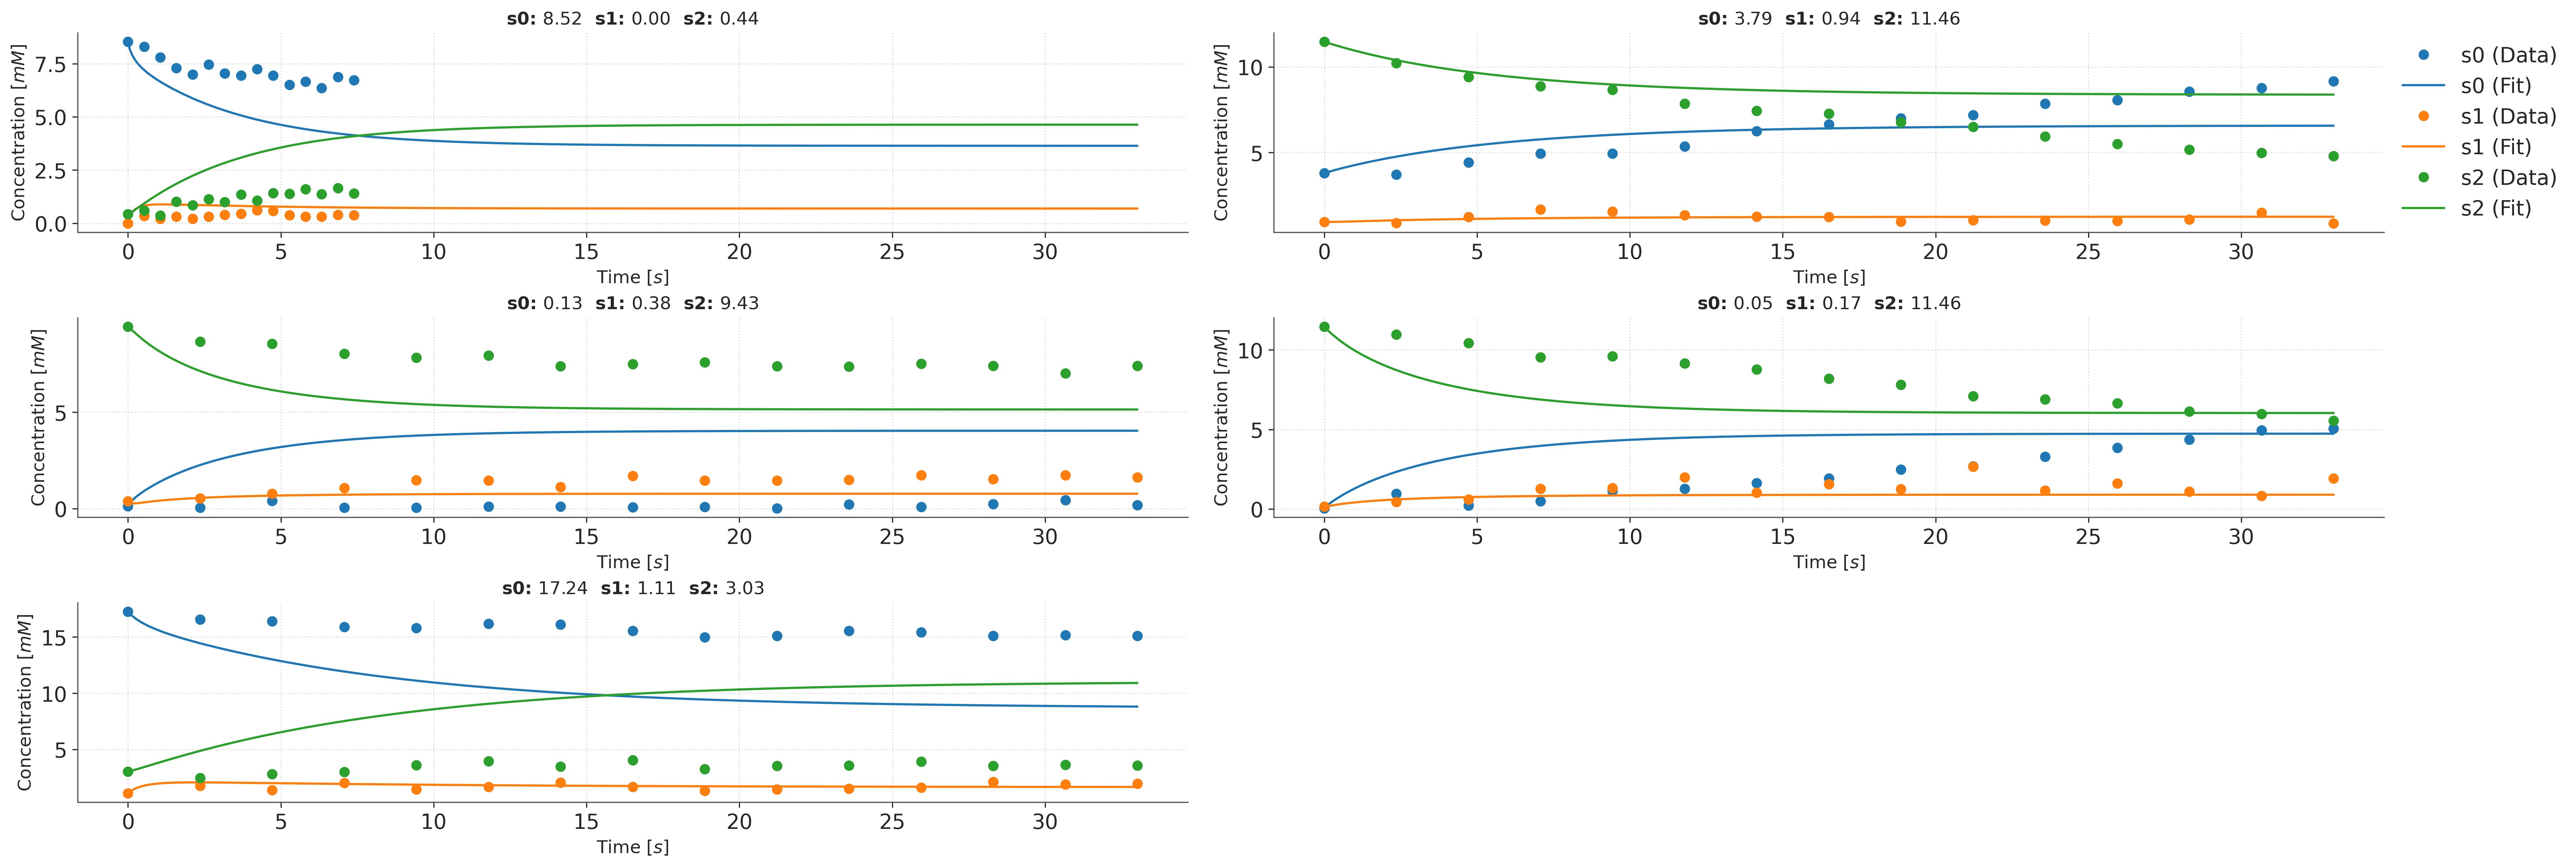

In [6]:
# Visualize the data
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:2],
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

In [7]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=10000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=30000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=50000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    sigma=0.03,
    n_augmentations=10,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False, # Set to True to save model checkpoints
    #log="progress.log", # Uncomment this line to log progress
)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\neural\rbf.py:25: FutureWarning: uniform accepts a single key, but was given a key array of shape (1, 2) != (). Use jax.vmap for batching. In a future JAX version, this will be an error.
  self.mu = jax.random.uniform(mukey, (width_size,))



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 0.0465 mae: 0.1636: : 10010it [02:24, 69.41it/s]                                                             




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.0551 mae: 0.2410: : 30010it [07:06, 70.33it/s]                                                             




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.0509 mae: 0.2343: : 50010it [11:51, 70.33it/s]                                                             

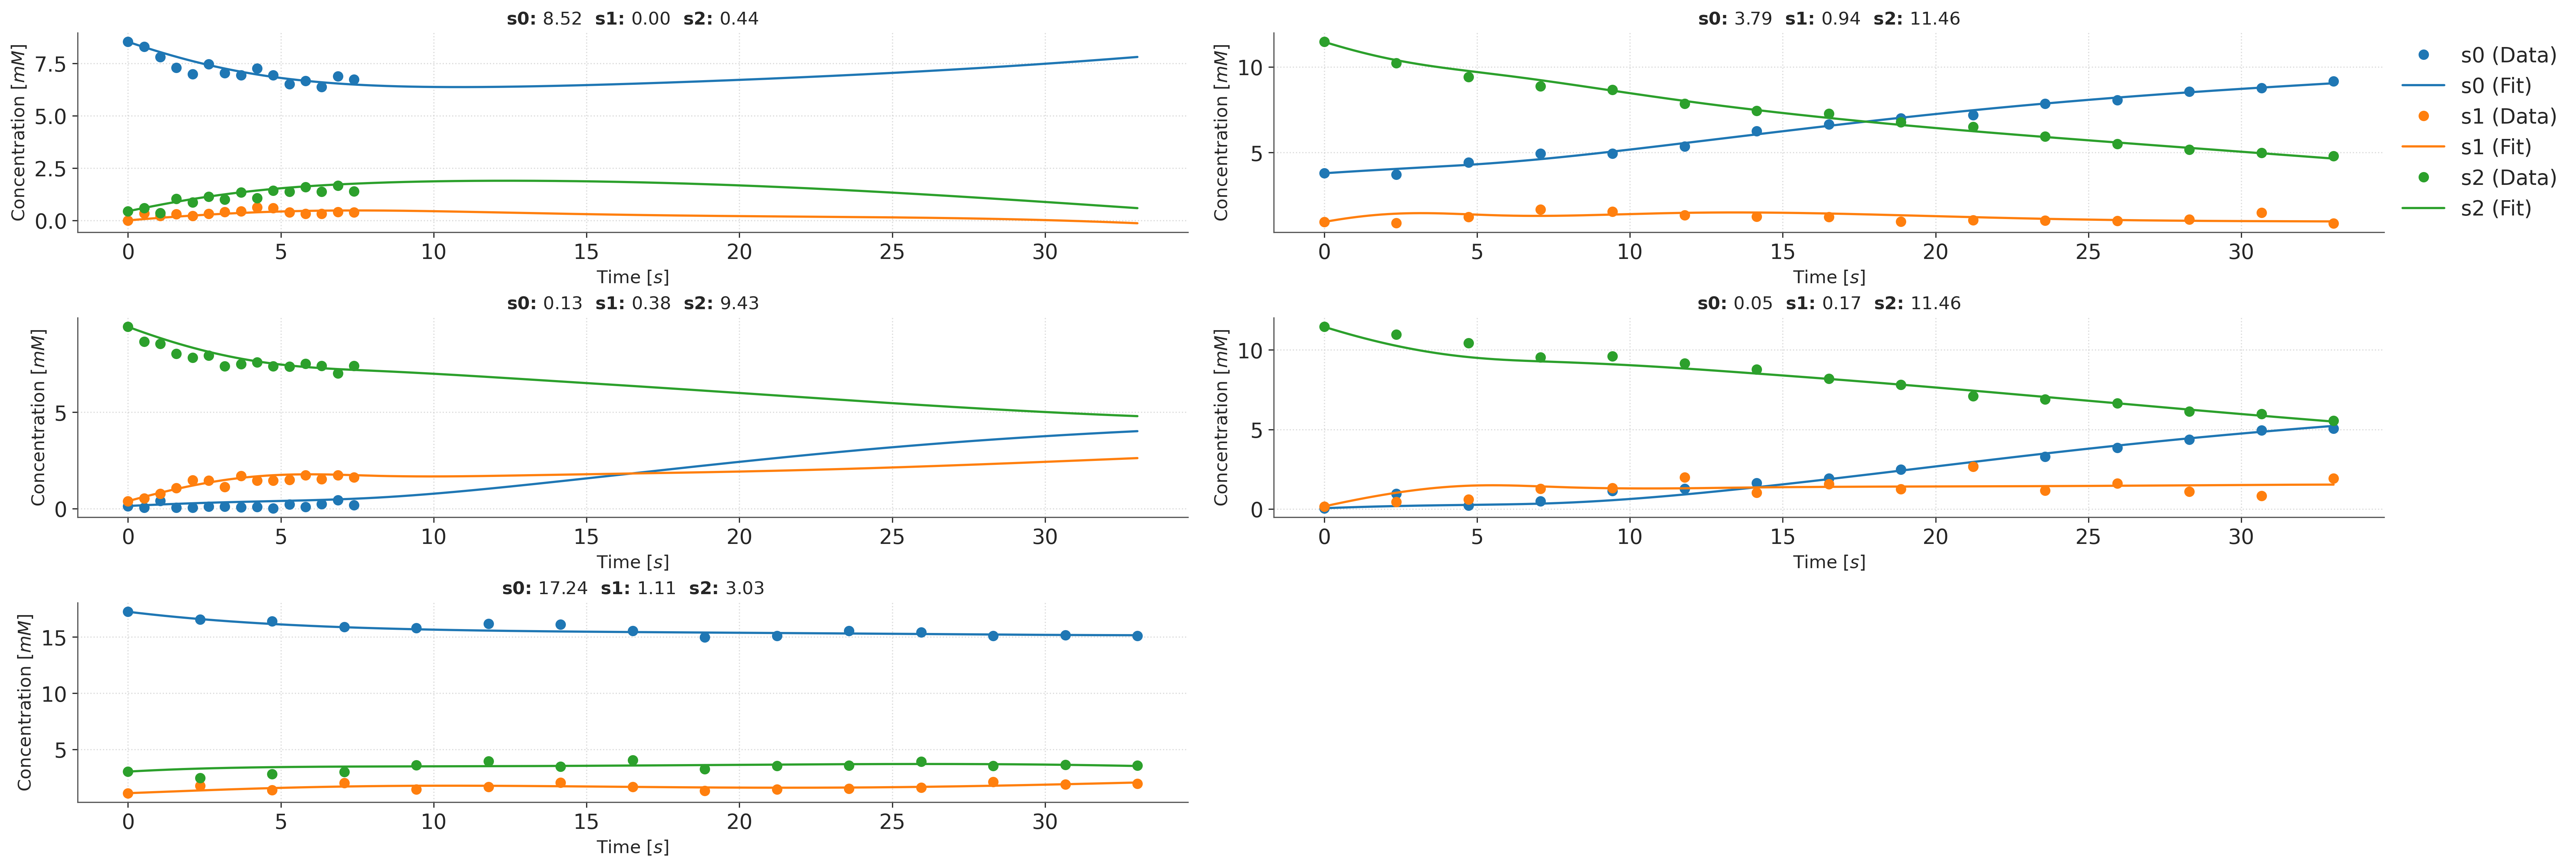

In [8]:
# Save model and visualize fit
trained.save_to_eqx("C:/Users/danic/OneDrive/Desktop/Masters Thesis/Kyle/", "Kamo_Trained_test1")
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:5],
    neural_ode=trained,
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

In [9]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)